<h1 align=center><font size = 5>THE BATTLE OF NEIGHBORHOODS IN PARIS</font></h1>
<h1 align=center><img src = "https://www.parisinfo.com/var/otcp/sites/images/node_43/node_51/node_230/vue-a%C3%A9rienne-paris-tour-eiffel-coucher-de-soleil-%7C-630x405-%7C-%C2%A9-fotolia/19544352-1-fre-FR/Vue-a%C3%A9rienne-Paris-Tour-Eiffel-coucher-de-soleil-%7C-630x405-%7C-%C2%A9-Fotolia.jpg" width = 400></h1>

<font color='00344D'><font size="5"> **0. Introduction** </font>


Paris is one of the most visited cities in the world. Unbeknownst to most (myself included before delving into the subject), each of its 20 Arrondissements (Districts) is divided into 4 Quartiers Administratifs or Neighborhoods, giving us a nice round number of 80 neighborhoods in total.

<img src = "https://upload.wikimedia.org/wikipedia/commons/e/e8/Les_quartiers_de_paris.png" width = 800></h1>
<font size = 1> *Wikipedia* 

#### **The problem to solve**

The problem I have chosen to solve for this capstone is the following :

It is easy to search for a specific venue or neighborhood on the web and get the desired information. However, what if someone is the type of person to plan ahead, including a time out. That person so happens to want to eat Chinese, go watch a movie, listen to music or browse for music, and finish the night at a bar. Quite ambitious I would say, what is there not to like in this plan ? Furthermore, it happens that this person is also efficient and does not want to go neighborhood-hopping. Lastly, this person doesn't necessarily care which neighborhood he goes to on this time out (of course assuming there's no confinement)

So in a nutshell, based on venue categories, return candidate neighborhoods.


But first, I would like to cluster the neighborhoods in Paris (section 4) since it's always interesting to see what k-means has to say, before going to section 5 where a solution to the problem is proposed.


#### **The stakeholders**

Anyone who wants to find a neighborhood with certain venue categories. It could be a tourist or a Parisien wanting to go visit places or go for a day/night out; it could be someone wanting to buy an appartment or rent a hotel where there's a specific venue category.


#### **The data**

The starting dataset will be obtained from data.gouv.fr and is composed the neighborhoods in Paris and certain characteristics such as their geographical coordinates, the surface area, and the district to which they belong.

As specified, Foursquare.com shall also be leveraged to obtain location data mainly concerning the venues in Paris.




<font color='00344D'><font size="5"> **1. Downloading libraries and Dependencies** 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0
import folium # map rendering library

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install xlrd

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.1.0                |     pyhd3deb0d_0          64 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          98 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.1.0-pyhd3deb0d_0



geopy-2.1.0          | 64 KB     | ##################################### | 100% 
geographiclib-1.50   | 34 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
Executing transaction: d

#### **Entering Foursquare credentials**

In [2]:
CLIENT_ID = '343X5E1LLLHSCDJZMMMIOFHYDWLNELRM10J5NDAD45K0TLH5' # your Foursquare ID
CLIENT_SECRET = '4EDFD31Z1EX3VTBKC5V2SO30HYLLXZ2Q3QJQYWT3D5ZP031B' # your Foursquare Secret
VERSION = '20190904'
LIMIT = 100
print('Foursquare credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Foursquare credentails:
CLIENT_ID: 343X5E1LLLHSCDJZMMMIOFHYDWLNELRM10J5NDAD45K0TLH5
CLIENT_SECRET:4EDFD31Z1EX3VTBKC5V2SO30HYLLXZ2Q3QJQYWT3D5ZP031B


<font color='00344D'><font size="5"> **2. Reading & cleaning data, and visualizing neighborhoods on a map** 

In [3]:
# Reading data in excel format to a dataframe
dfn = pd.read_excel('quartier_paris.xls')
dfn.head(2)

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000020,20,7510504,Sorbonne,5,750000005,2892.944068,433197.792441,"48.8490447659, 2.34574660019","{""type"": ""Polygon"", ""coordinates"": [[[2.349244..."
1,750000033,33,7510901,Saint-Georges,9,750000009,3429.188334,717091.569643,"48.8799343388, 2.33285019656","{""type"": ""Polygon"", ""coordinates"": [[[2.339228..."


In [4]:
# the latitude and longitude are found in the column 'Geometry X Y' - distinct columns are added to the dataframe to store these values
df_latlon = dfn['Geometry X Y']
dfn[['Latitude', 'Longitude']] = df_latlon.str.split(",",expand=True,)
dfn['Latitude'] = pd.to_numeric(dfn['Latitude'], downcast="float")
dfn['Longitude'] = pd.to_numeric(dfn['Longitude'], downcast="float")

# renaming columns and dropping columns that will not be used

df = dfn.rename(columns={"L_QU": "Neighborhood", "C_AR": "District" })
df = df.drop(columns=['N_SQ_QU', 'N_SQ_AR', 'C_QUINSEE','Geometry X Y', 'Geometry', 'PERIMETRE', 'SURFACE','C_QU'], axis = 1)

df['Neighborhood'] = df['Neighborhood'].replace({'Plaine de Monceaux':'Plaine-Monceau','Ternes':'Les Ternes', 'Epinettes':'Les Epinettes'})

df = df[[ 'District', 'Neighborhood','Latitude', 'Longitude']]

df = df.sort_values('District', ascending = True).reset_index(drop = True)

print(df.shape)
df.head()

(80, 4)


,District,Neighborhood,Latitude,Longitude
0,1,Place-Vendôme,48.867020,2.328582
1,1,Saint-Germain-l'Auxerrois,48.860649,2.334910
2,1,Palais-Royal,48.864658,2.336309
3,1,Halles,48.862289,2.344899
4,2,Gaillon,48.869308,2.333432


In [5]:
# Obtaining the coordinates of Paris

address = 'Paris, France'

geolocator = Nominatim(user_agent="paris_explorer")
location = geolocator.geocode(address)
lat_paris = location.latitude
long_paris = location.longitude

# Creating a map of Paris with its 80 neighborhoods as markers

map_paris = folium.Map(location=[lat_paris, long_paris], zoom_start=13)

# Adding markers to map
for lat, lng, district, neighborhood in zip(df['Latitude'], df['Longitude'], df['District'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='pink',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris)  
    
map_paris

I am not too happy with the markers for certain locations as they to correspond to the geographic center of the neighborhood; sometimes offset by large parks that make up these neighborhoods. For example, Auteuil's marker is offset towards Bois de Boulogne (bottom left of the map). No people live in Bois de Boulogne and Bois de Boulogne could be considered itself a venue. I'd rather focus on a point that corresponds more closely to the center of the 'neighborhood where people live', not necessarily the geographic center.


I will use geolocator instances to obtain new coordinates for certain neighborhoods. These neighborhoods are stored in the variable *pointstoswap*.

In [6]:
pointstoswap = ['Auteuil', 'Muette', 'Les Ternes', 'Bel-Air', 'Picpus', 'Batignolles', 'Villette', 'Porte-Dauphine', 'Les Epinettes']
df2 = df.loc[df['Neighborhood'].isin(pointstoswap)]
df2

,District,Neighborhood,Latitude,Longitude
44,12,Picpus,48.830360,2.428827
45,12,Bel-Air,48.837997,2.433178
60,16,Muette,48.863274,2.259936
62,16,Porte-Dauphine,48.871765,2.271918
63,16,Auteuil,48.850624,2.252277
64,17,Les Epinettes,48.894943,2.321119
65,17,Batignolles,48.888481,2.313856
67,17,Les Ternes,48.881176,2.289964
75,19,Villette,48.887661,2.374468


In [7]:
dflatlong2 = pd.DataFrame(columns = ['Latitudes', 'Longitudes'])


i = 0
for neigh in df2['Neighborhood']:
    locations = geolocator.geocode(str(neigh) + ', Paris')
    if locations is None:
        lat_new.append(neigh)
        long_new.append(neigh)
    else:
        latitudes = locations.latitude
        longitudes = locations.longitude  
    
    
    print(i, neigh, latitudes, longitudes)
    i = i+1

    dflatlong2 = dflatlong2.append({'Latitudes': latitudes,'Longitudes': longitudes}, ignore_index=True)

dflatlong2


0 Picpus 48.8450751 2.40108
1 Bel-Air 48.8413382 2.4009317
2 Muette 48.8579754 2.274062
3 Porte-Dauphine 48.871318 2.2777713
4 Auteuil 48.8477221 2.2667376
5 Les Epinettes 48.8932062 2.3228373
6 Batignolles 48.8863552 2.321457
7 Les Ternes 48.8807219 2.2944263
8 Villette 48.8904889 2.3800721


,Latitudes,Longitudes
0,48.845075,2.401080
1,48.841338,2.400932
2,48.857975,2.274062
3,48.871318,2.277771
4,48.847722,2.266738
5,48.893206,2.322837
6,48.886355,2.321457
7,48.880722,2.294426
8,48.890489,2.380072


In [8]:
df23 = df2.reset_index(drop = True)

df3 = pd.concat([df23, dflatlong2], axis = 1)

df3 = df3.drop(columns=['Latitude', 'Longitude'], axis = 1).rename(columns={"Latitudes": "Latitude", "Longitudes": "Longitude"})
df3

,District,Neighborhood,Latitude,Longitude
0,12,Picpus,48.845075,2.401080
1,12,Bel-Air,48.841338,2.400932
2,16,Muette,48.857975,2.274062
3,16,Porte-Dauphine,48.871318,2.277771
4,16,Auteuil,48.847722,2.266738
5,17,Les Epinettes,48.893206,2.322837
6,17,Batignolles,48.886355,2.321457
7,17,Les Ternes,48.880722,2.294426
8,19,Villette,48.890489,2.380072


In [9]:
df4 = df.loc[~df['Neighborhood'].isin(df3['Neighborhood'])]
df4 = pd.concat([df4,df3]).sort_values('District').reset_index(drop = True)
df4.shape

(80, 4)

In [10]:
map_paris2 = folium.Map(location=[lat_paris, long_paris], zoom_start=13)
# Adding markers to the map and visualizing the new data points for the neighborhoods
for lat, lng, neighborhood in zip(df4['Latitude'], df4['Longitude'], df4['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='cyan',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7,
        parse_html=False).add_to(map_paris2)  
    
map_paris2

The coordinates above seem to do the job; they shall be used in the rest of the notebook.

<font color='00344D'><font size="5"> **3. Exploring Neighborhoods in Paris** </font>

#### **The following function is borrowed from the lab to generate venues for each neighborhood by making an API call to Foursquare**

In [11]:
def getNearbyVenues(name, latitude, longitude, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(name, latitude, longitude):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['id'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue',
                  'Venue Id',
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Running the above function on each neighborhood

In [12]:
paris_venues = getNearbyVenues(name=df4['Neighborhood'],
                                   latitude=df4['Latitude'],
                                   longitude=df4['Longitude']
                                  )



Place-Vendôme
Saint-Germain-l'Auxerrois
Palais-Royal
Halles
Gaillon
Mail
Vivienne
Bonne-Nouvelle
Arts-et-Métiers
Archives
Enfants-Rouges
Sainte-Avoie
Notre-Dame
Saint-Gervais
Arsenal
Saint-Merri
Saint-Victor
Jardin-des-Plantes
Val-de-Grâce
Sorbonne
Monnaie
Odéon
Notre-Dame-des-Champs
Saint-Germain-des-Prés
Ecole-Militaire
Gros-Caillou
Saint-Thomas-d'Aquin
Invalides
Europe
Faubourg-du-Roule
Champs-Elysées
Madeleine
Faubourg-Montmartre
Saint-Georges
Chaussée-d'Antin
Rochechouart
Porte-Saint-Martin
Porte-Saint-Denis
Saint-Vincent-de-Paul
Hôpital-Saint-Louis
Roquette
Sainte-Marguerite
Saint-Ambroise
Folie-Méricourt
Bel-Air
Picpus
Bercy
Quinze-Vingts
Maison-Blanche
Gare
Croulebarbe
Salpêtrière
Plaisance
Parc-de-Montsouris
Petit-Montrouge
Montparnasse
Saint-Lambert
Javel
Grenelle
Necker
Auteuil
Porte-Dauphine
Muette
Chaillot
Plaine-Monceau
Les Ternes
Les Epinettes
Batignolles
Clignancourt
Goutte-d'Or
La Chapelle
Grandes-Carrières
Amérique
Combat
Pont-de-Flandre
Villette
Charonne
Saint-Fargea

In [13]:
paris_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Place-Vendôme,48.86702,2.328582,Hôtel Ritz,53b65301498e8cb57224f80c,48.868145,2.328962,Hotel
1,Place-Vendôme,48.86702,2.328582,Place Vendôme,4adcda09f964a5200e3421e3,48.867798,2.329741,Plaza
2,Place-Vendôme,48.86702,2.328582,CHANEL,4adcda1df964a5202a3921e3,48.868189,2.326634,Boutique
3,Place-Vendôme,48.86702,2.328582,Hôtel Mandarin Oriental,4d61286a1ee8721e010db321,48.866987,2.327178,Hotel
4,Place-Vendôme,48.86702,2.328582,Ladurée,50e16cdfe4b0439f0718ba5a,48.866121,2.328449,Dessert Shop


#### **The data resulting from the API call**

In [14]:
#I was wondering wether to remove duplicates since there is some overlap between neighborhoods. In the end, I decided not to remove duplicates as the radius that is taken into consideration through the api call defines our notion of neighborhood. So if you remove duplicates, you remove a characteristic of that said neighborhood.
#num_venues = paris_venues.shape[0]
#print('{} venues are returned'.format(num_venues))
#paris_venues = paris_venues.drop_duplicates(subset=['Venue Id'])

In [15]:
num_venues = paris_venues.shape[0]
dfcat = paris_venues.groupby('Venue Category').count()
dfcat_des = dfcat.sort_values(by = ['Venue'], ascending = False)

In [16]:
print('{} venues are returned, of which {} unique venue categories.'.format(num_venues, len(paris_venues['Venue Category'].unique())))
print('\n')
print('The top 20 categories returned and their frequency :','\n','\n',dfcat_des.iloc[0:20]['Neighborhood'])
print('\n')
paris_venues.head()

5263 venues are returned, of which 300 unique venue categories.


The top 20 categories returned and their frequency : 
 
 Venue Category
French Restaurant      702
Hotel                  425
Italian Restaurant     196
Bakery                 168
Bar                    145
Japanese Restaurant    139
Café                   139
Bistro                 117
Plaza                  117
Coffee Shop            115
Wine Bar                94
Restaurant              88
Pizza Place             82
Cocktail Bar            76
Supermarket             66
Sandwich Place          57
Park                    53
Chinese Restaurant      51
Clothing Store          51
Burger Joint            50
Name: Neighborhood, dtype: int64




,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
0,Place-Vendôme,48.86702,2.328582,Hôtel Ritz,53b65301498e8cb57224f80c,48.868145,2.328962,Hotel
1,Place-Vendôme,48.86702,2.328582,Place Vendôme,4adcda09f964a5200e3421e3,48.867798,2.329741,Plaza
2,Place-Vendôme,48.86702,2.328582,CHANEL,4adcda1df964a5202a3921e3,48.868189,2.326634,Boutique
3,Place-Vendôme,48.86702,2.328582,Hôtel Mandarin Oriental,4d61286a1ee8721e010db321,48.866987,2.327178,Hotel
4,Place-Vendôme,48.86702,2.328582,Ladurée,50e16cdfe4b0439f0718ba5a,48.866121,2.328449,Dessert Shop


#### *The following cells consist of data manipulation for the Clustering in section 4. To see the results of the project, you may if you wish skip directly to section 5.*

#### **Analyzing neighborhoods**

In [17]:
#borrowed from the lab as well

#one hot encoding
paris_onehot = pd.get_dummies(paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighborhood'] = paris_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [paris_onehot.columns[-1]] + list(paris_onehot.columns[:-1])
paris_onehot = paris_onehot[fixed_columns]

print(paris_onehot.shape)
paris_onehot.head()

(5263, 301)


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szech

#### **Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category**

In [18]:
paris_grouped = paris_onehot.groupby('Neighborhood').mean().reset_index()
print(paris_grouped.shape)
paris_grouped.head()

(80, 301)


,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szech

#### **Top 10 Venue Categories by Neighborhood**

In [19]:
num_top_venues = 10

for hood in paris_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Amérique----
               venue  freq
0  French Restaurant  0.18
1        Supermarket  0.18
2              Plaza  0.09
3            Theater  0.09
4    Bed & Breakfast  0.09
5               Café  0.09
6             Bistro  0.09
7               Park  0.09
8               Pool  0.09
9          Newsstand  0.00


----Archives----
                venue  freq
0   French Restaurant  0.11
1               Hotel  0.06
2         Coffee Shop  0.05
3      Clothing Store  0.05
4         Art Gallery  0.04
5                 Bar  0.04
6  Italian Restaurant  0.03
7              Bistro  0.03
8           Bookstore  0.03
9        Cocktail Bar  0.03


----Arsenal----
                           venue  freq
0              French Restaurant  0.19
1                          Hotel  0.09
2                          Plaza  0.04
3                      Gastropub  0.04
4                           Park  0.04
5               Pedestrian Plaza  0.03
6  Vegetarian / Vegan Restaurant  0.03
7               Tapas Restaur

#### **Storing the data in a dataframe**

In [20]:
#function borrowed from lab to sort venues from highest to lowest

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Creating the new dataframe and displaying the top 10 venues for each neighborhood

In [21]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = paris_grouped['Neighborhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(2)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Amérique,French Restaurant,Supermarket,Pool,Café,Plaza,Park,Bed & Breakfast,Bistro,Theater,Escape Room
1,Archives,French Restaurant,Hotel,Coffee Shop,Clothing Store,Art Gallery,Bar,Plaza,Bistro,Bookstore,Cocktail Bar


<a id='item4'></a>

<font color='00344D'><font size="5"> **4. Clustering Neighborhoods using K-Means** </font>

Since the values of the following dataframe that is fed to the K-means algorithm contains values that are already between 0 and 1, no pre-processing will be performed.

In [22]:
paris_grouped.head(2)

,Neighborhood,Accessories Store,Afghan Restaurant,African Restaurant,Alsatian Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auvergne Restaurant,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Basketball Court,Basque Restaurant,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Breton Restaurant,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burgundian Restaurant,Bus Line,Bus Station,Bus Stop,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Canal,Canal Lock,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Ch'ti Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Corsican Restaurant,Cosmetics Shop,Costume Shop,Creperie,Cultural Center,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dive Spot,Doner Restaurant,Donut Shop,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Escape Room,Ethiopian Restaurant,Exhibit,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hawaiian Restaurant,Health Food Store,Herbs & Spices Store,Historic Site,History Museum,Hobby Shop,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Jiangxi Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Korean BBQ Restaurant,Korean Restaurant,Latin American Restaurant,Laundromat,Leather Goods Store,Lebanese Restaurant,Lingerie Store,Liquor Store,Lounge,Lyonese Bouchon,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music Store,Music Venue,New American Restaurant,Newsstand,Nightclub,Noodle House,Office,Okonomiyaki Restaurant,Opera House,Optical Shop,Organic Grocery,Outdoor Sculpture,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Perfume Shop,Peruvian Restaurant,Pet Café,Pharmacy,Photography Lab,Pie Shop,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Provençal Restaurant,Pub,Ramen Restaurant,Record Shop,Resort,Restaurant,Rock Club,Romanian Restaurant,Roof Deck,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Savoyard Restaurant,Scandinavian Restaurant,Scenic Lookout,School,Science Museum,Sculpture Garden,Seafood Restaurant,Shanxi Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Snack Place,Soba Restaurant,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Southern / Soul Food Restaurant,Southwestern French Restaurant,Souvenir Shop,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Syrian Restaurant,Szech

Using the elbow method, the following will be used to determine a good number of clusters.

Text(0, 0.5, 'Inertia')

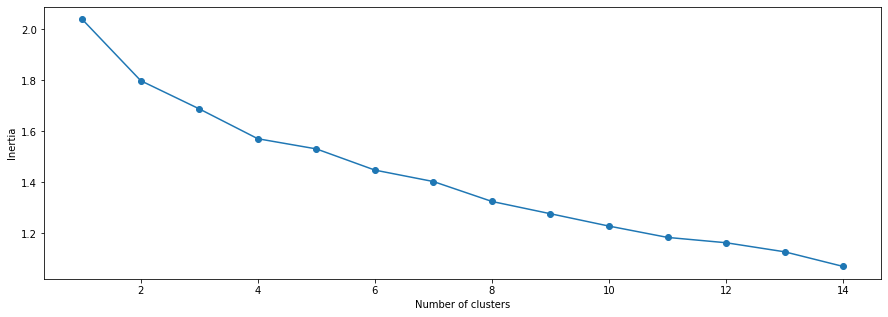

In [24]:
paris_grouped_clustering = paris_grouped.drop('Neighborhood', 1)

SSE = []
for cluster in range(1,15):
    kmeans = KMeans(n_clusters = cluster, random_state=1)
    #kmeans = KMeans(n_clusters = cluster, random_state=0)
    kmeans.fit(paris_grouped_clustering)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,15), 'SSE':SSE})
plt.figure(figsize=(15,5))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [31]:
# set number of clusters - I have chosen 6 clusters since there's a mini elbow at 6 on the figure.
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=1).fit(paris_grouped_clustering)

In [30]:
# in case need to rerun kmeans
#neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop('Cluster Labels', axis = 1)

In [32]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
paris_merged = df4

paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

paris_merged.head()

,District,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Place-Vendôme,48.867020,2.328582,5,Hotel,French Restaurant,Jewelry Store,Boutique,Japanese Restaurant,Chocolate Shop,Plaza,Dessert Shop,Hotel Bar,Bookstore
1,1,Saint-Germain-l'Auxerrois,48.860649,2.334910,5,Hotel,French Restaurant,Plaza,Historic Site,Coffee Shop,Art Museum,Café,Cosmetics Shop,Italian Restaurant,Fountain
2,1,Palais-Royal,48.864658,2.336309,3,Japanese Restaurant,Hotel,French Restaurant,Plaza,Italian Restaurant,Café,Historic Site,Wine Bar,Coffee Shop,Theater
3,1,Halles,48.862289,2.344899,3,French Restaurant,Coffee Shop,Pedestrian Plaza,Clothing Store,Plaza,Spa,Furniture / Home Store,Bakery,Art Gallery,Sandwich Place
4,2,Gaillon,48.869308,2.333432,3,Japanese Restaurant,Hotel,French Restaurant,Korean Restaurant,Bakery,Wine Bar,Chocolate Shop,Plaza,Coffee Shop,Italian Restaurant


In [33]:
# create map
map_clusters = folium.Map(location=[lat_paris, long_paris], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'], paris_merged['Longitude'], paris_merged['Neighborhood'], paris_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

#### **Examining Clusters**

In [34]:
b = len(paris_merged['Cluster Labels'].unique().tolist())

In [35]:
aa = paris_merged.groupby('Cluster Labels').count()
print('Number of Neighborhoods per cluster', '\n''\n', aa.iloc[0:kclusters]['Neighborhood'])

Number of Neighborhoods per cluster 

 Cluster Labels
0     4
1     8
2    26
3    22
4    13
5     7
Name: Neighborhood, dtype: int64


In [36]:
x = 0

print('Neighborhoods in each cluster','\n')

for x in range(b):
    print('Cluster ' + str(x))
    boo = paris_merged[paris_merged['Cluster Labels'] == x].T.reset_index()
    print(boo.iloc[1][1:80].reset_index(drop=True))
    print('\n')


Neighborhoods in each cluster 

Cluster 0
0      Goutte-d'Or
1      La Chapelle
2         Amérique
3    Saint-Fargeau
Name: 1, dtype: object


Cluster 1
0                 Arsenal
1            Gros-Caillou
2    Saint-Thomas-d'Aquin
3               Invalides
4                  Europe
5            Rochechouart
6                Chaillot
7              Les Ternes
Name: 1, dtype: object


Cluster 2
0     Notre-Dame-des-Champs
1       Faubourg-Montmartre
2             Saint-Georges
3         Porte-Saint-Denis
4     Saint-Vincent-de-Paul
5                   Bel-Air
6                    Picpus
7            Maison-Blanche
8                      Gare
9               Croulebarbe
10              Salpêtrière
11       Parc-de-Montsouris
12          Petit-Montrouge
13             Montparnasse
14            Saint-Lambert
15                    Javel
16                 Grenelle
17                   Necker
18                  Auteuil
19           Porte-Dauphine
20                   Muette
21           Pla

#### **Top 2 venues in each neighborhoods, by Cluster**

In [32]:
y = 0

for y in range(kclusters):
    print('Cluster ' + str(y))
    print(paris_merged.loc[paris_merged['Cluster Labels'] == y, paris_merged.columns[[1] + list(range(5, 7))]])
    print('\n')


Cluster 0
             Neighborhood 1st Most Common Venue     2nd Most Common Venue
2            Palais-Royal   Japanese Restaurant         French Restaurant
4                 Gaillon   Japanese Restaurant                     Hotel
6                Vivienne     French Restaurant                     Hotel
10         Enfants-Rouges                 Hotel         French Restaurant
21                  Odéon                 Hotel                      Café
34       Chaussée-d'Antin                 Hotel         French Restaurant
37      Porte-Saint-Denis                 Hotel         French Restaurant
38  Saint-Vincent-de-Paul     Indian Restaurant         French Restaurant
44                Bel-Air     French Restaurant                     Hotel
45                 Picpus                 Hotel         French Restaurant
46                  Bercy                 Hotel  Bike Rental / Bike Share
48         Maison-Blanche                Bakery         French Restaurant
49                   Gare   

<font color='00344D'><font size="5"> **5. Finding neighborhoods with different venue categories**</font>

In [37]:
number = []
inp = input('How many Venue Categories would you like in your neighborhood ?')
inp = int(inp)

for n in range(inp):
    n = input('What are they?')
    n = n.capitalize()
    number.append(n)

    
s = ''
for m in number:
        s += m + '|'
                
blob = s[:-1]

df_t = paris_venues[paris_venues['Venue Category'].str.contains(blob)].reset_index(drop = True).sort_values(by = 'Neighborhood')
df_t.head()

How many Venue Categories would you like in your neighborhood ? 6
What are they? chinese
What are they? movie
What are they? cafe
What are they? music
What are they? italian
What are they? bar


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category
125,Archives,48.859192,2.363205,Rivolux,4bb88cce98c7ef3b6f2a3102,48.855590,2.359419,Bar
120,Archives,48.859192,2.363205,Candelaria,4d77b39caf63cbff3997be0f,48.863032,2.364059,Cocktail Bar
121,Archives,48.859192,2.363205,Les Enfants Rouges,52505ced11d2d39c3cd942a6,48.863013,2.361260,Wine Bar
122,Archives,48.859192,2.363205,Pasta Linea,4bc0b177abf495214aa7bf93,48.855250,2.363416,Italian Restaurant
123,Archives,48.859192,2.363205,Résistance,555fa507498efe354e7b7f53,48.858042,2.356651,Cocktail Bar


In [40]:
df_b.groupby(['Neighborhood', 'Venue Category']).size()

Neighborhood        Venue Category     
Bonne-Nouvelle      Bar                    3
                    Beer Bar               1
                    Chinese Restaurant     2
                    Cocktail Bar           7
                    Gaming Cafe            1
                    Indie Movie Theater    1
                    Italian Restaurant     4
                    Music Store            1
                    Wine Bar               6
Porte-Saint-Martin  Bar                    1
                    Chinese Restaurant     1
                    Cocktail Bar           2
                    Gaming Cafe            1
                    Indie Movie Theater    2
                    Italian Restaurant     2
                    Juice Bar              1
                    Music Store            1
                    Wine Bar               1
dtype: int64

In [41]:
df_d = df4[['District', 'Neighborhood']]
df_c = df_b.join(df_d.set_index('Neighborhood'), on='Neighborhood')
df_c.head()#d = df_c[['District']].groupby(['District']).count()
#df_cd

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Id,Venue Latitude,Venue Longitude,Venue Category,District
69,Bonne-Nouvelle,48.867149,2.35008,Experimental Cocktail Club,4b181e1cf964a5203acd23e3,48.866151,2.348370,Cocktail Bar,2
65,Bonne-Nouvelle,48.867149,2.35008,Hoppy Corner,57054c44498ed5a375ce4b86,48.867726,2.347375,Beer Bar,2
70,Bonne-Nouvelle,48.867149,2.35008,Frenchie Bar A Vins,578161c1498eb537b596b391,48.867812,2.347917,Wine Bar,2
67,Bonne-Nouvelle,48.867149,2.35008,Ma Cave Fleury,4b894a17f964a520de2832e3,48.865505,2.350544,Wine Bar,2
71,Bonne-Nouvelle,48.867149,2.35008,Player One,5be1ca0de07550002c0f68d9,48.868272,2.352039,Bar,2


In [42]:
# Creating a map
mappa = folium.Map(location=[lat_paris, long_paris], zoom_start=13)



    
for lat, lng, venue, neighborhood, cat in zip(df_b['Neighborhood Latitude'], df_b['Neighborhood Longitude'], df_b['Venue'], df_b['Neighborhood'], df_b['Venue Category']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=50,
        popup=label,
        color='',
        fill=True,
        fill_color='grey',
        fill_opacity=0.2,
        parse_html=False).add_to(mappa)   
    
    
# Adding markers to map
for latv, lngv, venue, neighborhood, cat in zip(df_b['Venue Latitude'], df_b['Venue Longitude'], df_b['Venue'], df_b['Neighborhood'], df_b['Venue Category']):
    label = '{}, {}, {}'.format(venue, cat, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latv, lngv],
        radius=5,
        popup=label,
        color='',
        fill=True,
        fill_color='red',
        fill_opacity=0.7,
        parse_html=False).add_to(mappa)
    
mappa



#### **Going Further**

This project yielded results, but could be improved as using neighborhoods may not be as ideal as creating a grid. The reason is that not only do districts vary in surface/size, but also neighborhoods. Since their shapes are variable, some are close to each other, some are very spaced out compared to others; the value of the radius used to make the Foursquare API call is too large or too small in many cases. Using a grid with evenly spaced locations would not only result in better coverage of the surface (we would get more venues), but also would prevent from creating any overlap (2 or more neighborhoods sharing the same venue).



In [209]:
print('Thanks for reading and be well')
# please excuse the lack of elegance in writing some of the code

Thanks for reading and be well
